# Explaining cortical thickness development: Confirmation in developmental gene expression data

In [1]:
import os
import sys
from os.path import join
import re
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib import pyplot as plt
import seaborn as sns

from skmisc.loess import loess
from joblib import Parallel, delayed

# custom functions
from scripts.utils import na

# working path
wd = os.path.dirname(os.path.realpath("__file__"))
print("Working directory:", wd)

# JuSpyce
sys.path.append(os.path.dirname(join(wd, "scripts", "juspyce")))
from juspyce.api import JuSpyce
from scripts.juspyce.stats import mc_correction, null_to_p

# data directory
gene_dir = join(wd, "data_expression")

# plot directory
plot_dir = join(wd, "plots", "expression")

# number of permutations
n_perm = 10000

Working directory: /Users/llotter/projects/CTdev


## Get data


### Get main CT prediction results

In [2]:
# load JuSpyce object
juspyce_ct_slr = JuSpyce.from_pickle(\
    join(wd, "data_rutherford", f"juspyce_ct_slr_fm_500_5.pkl.gz"))

# predictors
predictors_all = juspyce_ct_slr.x_lab.to_list()
# significant predictors
predictors_sig = np.array(juspyce_ct_slr.x_lab) \
    [(juspyce_ct_slr.p_predictions["slr--fdr_bh"] < 0.05).any()].tolist()
# significant predictors with peak in postmortem age range
predictors_sig_pm = juspyce_ct_slr.predictions["slr"][predictors_sig].iloc[1:,:].idxmax()
predictors_sig_pm = [i for i in predictors_sig_pm.index if int(predictors_sig_pm[i].replace("Δ(","").replace(")","").split(",")[0]) <= 83]
# sort predictors by peak age
max_pred = juspyce_ct_slr.predictions["slr"].iloc[1:,:][predictors_sig_pm].idxmax()
max_pred_i = np.argsort([int(max_pred[i].replace("Δ(","").split(",")[0]) for i in range(len(max_pred))])
predictors_sig_pm_sorted = max_pred.iloc[max_pred_i].index.to_list()
# print
print(f"p(FDR) < 0.05: n = {len(predictors_sig)}\n", predictors_sig)
print(f"p(FDR) < 0.05 & peak < 82 years: n = {len(predictors_sig_pm)}\n", predictors_sig_pm)
# get data
ct_predictions = [ juspyce_ct_slr.predictions["slr"][predictors_sig_pm] ]

# get all original predictor data associate with predictors_sig_pm 
for pred in predictors_sig_pm:
    # load original predictor juspyce data
    juspyce_ct_orig = JuSpyce.from_pickle(\
        join(wd, "data_rutherford", f"juspyce_ct_dominance_single_{pred.split('-')[0]}_fm_500_5.pkl.gz"))
    ct_predictions.append( juspyce_ct_orig.predictions["dominance_individual"] )

# predictor df
ct_predictions = pd.concat(ct_predictions, axis=1).iloc[1:,]
# drop duplicated columns
ct_predictions = ct_predictions.loc[:, ~ct_predictions.columns.duplicated()]
# drop CBF because we have no associated genetic data 
ct_predictions = ct_predictions.drop(columns="CBF")
ct_predictions.head(5)

INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_slr_fm_500_5.pkl.gz.


p(FDR) < 0.05: n = 9
 ['ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8']
p(FDR) < 0.05 & peak < 82 years: n = 9
 ['ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8']


INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ni3_fm_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ni4_fm_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ni5_fm_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ni6_fm_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ni9_fm_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ce3_fm_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ce4_fm_500_5.pkl.gz.
INFO:juspyce.api:Loa

,ni3-FDOPA-DAT-D1-NMDA,ni4-GI-5HT1b-MU-A4B2,ni5-VAChT-NET,ni6-CBF-CMRglu,ni9-D2,ce3-Micro-OPC,ce4-In3-In2-Astro,ce5-In6-Ex2,ce9-In8,FDOPA,...,Micro,OPC,Ex3,In2,In3,Astro,In6,Ex2,In4,In8
"Δ(5,10)",-0.004889,0.030006,-0.001890,0.154267,0.296306,0.169572,-0.004719,0.050207,0.154611,-0.006424,...,0.086295,0.093020,0.106005,-0.006428,-0.006794,-0.001331,-0.005344,0.129247,0.086218,0.088771
"Δ(6,11)",-0.005831,0.041104,-0.003053,0.162875,0.310451,0.181371,-0.003990,0.062530,0.154259,-0.006819,...,0.091869,0.097129,0.103799,-0.006461,-0.006919,-0.002001,-0.006643,0.146849,0.086654,0.079891
"Δ(7,12)",-0.006521,0.055001,-0.004267,0.171620,0.324302,0.193609,-0.003041,0.077465,0.152751,-0.006732,...,0.097403,0.100870,0.100323,-0.006490,-0.006934,-0.002742,-0.006874,0.167118,0.086521,0.069869
"Δ(8,13)",-0.006895,0.072117,-0.005431,0.180165,0.337077,0.205818,-0.001837,0.095302,0.149700,-0.006036,...,0.102616,0.103933,0.095343,-0.006517,-0.006783,-0.003532,-0.005539,0.190054,0.085580,0.058776
"Δ(9,14)",-0.006894,0.092719,-0.006388,0.188009,0.347695,0.217280,-0.000356,0.116151,0.144687,-0.004608,...,0.107106,0.105916,0.088663,-0.006546,-0.006409,-0.004338,-0.002055,0.215343,0.083555,0.046843


#### Get the time periods of significant CT prediction

In [3]:
ct_prediction_idc, ct_prediction_period = {}, {}
for pred in predictors_sig_pm_sorted:
    temp = juspyce_ct_slr.p_predictions["slr--fdr_bh"][pred][1:]
    temp = temp[temp < 0.05].index.to_list()
    ct_prediction_idc[pred] = temp
    ct_prediction_period[pred] = (
        int(re.search(r'\((\d+),\d+\)', temp[0]).group(1)),
        int(re.search(r'\(\d+,(\d+)\)', temp[-1]).group(1))
    )
    if ct_prediction_period[pred][1] > 82:
        print(pred, "end age", ct_prediction_period[pred][1], "> 82, replace by 82")
        ct_prediction_period[pred] = (ct_prediction_period[pred][0], 82)
ct_prediction_period

ce4-In3-In2-Astro end age 85 > 82, replace by 82


{'ce9-In8': (5, 17),
 'ni9-D2': (5, 32),
 'ce3-Micro-OPC': (5, 23),
 'ni4-GI-5HT1b-MU-A4B2': (13, 32),
 'ce5-In6-Ex2': (10, 34),
 'ni6-CBF-CMRglu': (6, 38),
 'ni3-FDOPA-DAT-D1-NMDA': (32, 41),
 'ni5-VAChT-NET': (27, 57),
 'ce4-In3-In2-Astro': (74, 82)}

### Get factor loadings

In [4]:
# factor loadings from original analyses
loadings = pd.concat([
    pd.read_csv(join(wd, "data_predictors", "cell_factorloadings_destrieux.csv"), index_col=0),
    pd.read_csv(join(wd, "data_predictors", "ni_factorloadings_destrieux.csv"), index_col=0)
])
loadings = loadings.drop(index="CBF")
display(loadings.head(5))

# for each factor-level predictor, get maximum 5 original predictors that load > 0.3 on the factor
preds_orig = {}
for pred in predictors_sig_pm_sorted:
    preds_orig[pred] = \
        loadings[pred].abs()[loadings[pred].abs() > 0.3].sort_values(ascending=False).index.to_list()[:5]
display(preds_orig)

# as list
preds_orig_all = list(set(sum([preds_orig[pred] for pred in preds_orig], [])))
print(preds_orig_all)

,ce1-Ex7-In4-Ex5-Ex4-In1,ce2-Oligo-Endo,ce3-Micro-OPC,ce4-In3-In2-Astro,ce5-In6-Ex2,ce6-Ex8-Ex6,ce7-In7-Ex3,ce8-In5,ce9-In8,ce10-Ex1,ni1-SV2A-M1-mGluR5-5HT6-CB1-GABAa-HDAC,ni2-5HT2a-5HT4-5HT1a-5HTT,ni3-FDOPA-DAT-D1-NMDA,ni4-GI-5HT1b-MU-A4B2,ni5-VAChT-NET,ni6-CBF-CMRglu,ni7-COX1,ni8-H3,ni9-D2,ni10-TSPO
Ex1,0.185792,-0.176964,0.146974,0.030688,-0.103914,-0.010363,0.182920,0.072977,-0.048231,0.857666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ex2,0.091000,0.212107,-0.293412,-0.007159,0.406008,0.251220,-0.302233,0.062840,0.271652,-0.109766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ex3,-0.300766,-0.301274,-0.366140,0.013702,0.157322,-0.007006,0.475764,-0.096884,0.335164,-0.040547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ex4,0.662913,-0.189216,-0.099984,0.187634,0.127367,0.030420,-0.093912,0.289826,-0.042798,0.076038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ex5,0.667768,-0.348302,-0.107953,0.038756,0.185613,0.326709,0.106128,0.080017,-0.068025,0.061140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


{'ce9-In8': ['In8', 'Ex3'],
 'ni9-D2': ['GABAa', 'D2', 'D1'],
 'ce3-Micro-OPC': ['Micro', 'OPC', 'Ex3', 'In2'],
 'ni4-GI-5HT1b-MU-A4B2': ['GI', '5HT1b', 'MU', 'A4B2', '5HT6'],
 'ce5-In6-Ex2': ['In6', 'Ex2', 'In4'],
 'ni6-CBF-CMRglu': ['CMRglu'],
 'ni3-FDOPA-DAT-D1-NMDA': ['FDOPA', 'DAT', 'D1', 'NET', 'NMDA'],
 'ni5-VAChT-NET': ['VAChT', 'NET', 'A4B2'],
 'ce4-In3-In2-Astro': ['In3', 'In2', 'Astro']}

['In2', 'Micro', 'DAT', 'In8', 'NMDA', 'GI', 'MU', 'Ex2', 'GABAa', '5HT6', 'D2', 'FDOPA', 'CMRglu', 'In4', 'NET', '5HT1b', 'In3', 'Astro', 'VAChT', 'A4B2', 'In6', 'OPC', 'Ex3', 'D1']


### HBT data

In [5]:
# Kang et al., Nature 2011 expression data (https://hbatlas.org/pages/data)
expr_hbt = pd.read_csv(join(gene_dir, "Kang2011_expr_matrix.csv.gz"))
# new indices
expr_hbt = expr_hbt.set_index("Gene.Symbol").iloc[:, 20:].T
expr_hbt.index = pd.MultiIndex.from_tuples(
    [("HSB" + i.split(".")[0][1:], i.split(".")[1], i.split(".")[2]) for i in expr_hbt.index], names=["id", "reg", "hemi"]
)
expr_hbt.columns.name = ""
expr_hbt = expr_hbt.sort_index()

# show
print(f"Expression table (len = {len(expr_hbt)})")
display(expr_hbt.head(2))


# sample data 1 (https://hbatlas.org/pages/data)
samples_hbt_1 = pd.read_excel(
    join(gene_dir, "Kang2011_suppl_tables.xls"), 
    sheet_name="Supple Table 1.",
    header=1
)
# fill na values
samples_hbt_1["Brain code"] = samples_hbt_1["Brain code"].fillna(method="ffill")
# to wide format
samples_hbt_1 = samples_hbt_1.pivot(index="Brain code", columns="Features", values="Values")
samples_hbt_1.columns.name = ""
# period string
samples_hbt_1["Period_desc"] = [s.split(", ")[1] for s in samples_hbt_1.Period]
# id variable
samples_hbt_1["sub_id"] = samples_hbt_1.index
samples_hbt_1.index.name = "id"
# numeric age variable, zero = birth
temp = []
for a in samples_hbt_1["Age"]:
    a, unit = re.split(r'\s+', a)
    if unit=="Y":
        temp.append( float(a) * 365.25 )
    elif unit=="M":
        temp.append( float(a) * 30.437 )
    elif unit=="PCW":
        temp.append( -(280 - float(a) * 7))
samples_hbt_1["age_days"] = np.array(temp).round(0)
# numeric age variable, zero = conception
temp = []
for a in samples_hbt_1["Age"]:
    a, unit = re.split(r'\s+', a)
    if unit=="Y":
        temp.append( float(a) * 365.25 + 280)
    elif unit=="M":
        temp.append( float(a) * 30.437 + 280)
    elif unit=="PCW":
        temp.append( float(a) * 7)
samples_hbt_1["age_days_conception"] = np.array(temp).round(0)
# show
print(f"Sample table 1 (len = {len(samples_hbt_1)})")
display(samples_hbt_1.head(2))

# sample data 2 (https://hbatlas.org/pages/data)
samples_hbt_2 = pd.read_excel(
    join(gene_dir, "Kang2011_suppl_tables.xls"), 
    sheet_name="Supple Table 4.",
    header=1
)
samples_hbt_2 = samples_hbt_2.set_index(["Brain code"])
samples_hbt_2.index.name = "id"
# show
print(f"Sample table 2 (len = {len(samples_hbt_2)})")
display(samples_hbt_2.head(2))

# merge
samples_hbt = samples_hbt_2.merge(
    samples_hbt_1[["sub_id", "age_days", "age_days_conception", "Age", "Ethnicity", "PMI", "Period_desc", "Sex", "pH"]], 
    left_index=True, right_index=True, how="left"
)
# new indices
samples_hbt.columns = [c.lower() for c in samples_hbt.columns]
samples_hbt = samples_hbt.set_index(["region/area", "hemisphere"], append=True, drop=False)
samples_hbt.index.names = ["id", "reg", "hemi"]
samples_hbt = samples_hbt.sort_index()

# show
print(f"Merged table (len = {len(samples_hbt)})")
display(samples_hbt.head(2)) 

Expression table (len = 1340)


TM9SF4     SCAP     FAF2  DCUN1D2     APOM   SLC9A1  \
id     reg hemi                                                         
HSB100 A1C L     9.60586  8.75448  9.16721  6.57221  4.49622  6.52169   
           R     9.67331  8.22599  9.28183  6.19931  4.51736  6.81342   

                   ARRB1     SFRS2  SLC16A4  FLJ42875  ...    JMJD6    ACRBP  \
id     reg hemi                                        ...                     
HSB100 A1C L     11.2153  10.15680  4.48054   6.63585  ...  7.49951  4.42885   
           R     11.0591   9.63033  4.64547   6.08970  ...  7.51302  4.03080   

                 C15orf40     SOX1  C1orf105   HIGD2A    TRYX3  CCDC117  \
id     reg hemi                                                           
HSB100 A1C L      6.16709  6.08505   4.02924  7.62629  3.74191  8.27000   
           R      6.12981  5.72072   3.79548  8.95419  3.51433  8.30181   

                  DZIP1L    FRAS1  
id     reg hemi                    
HSB100 A1C L     4.81064  6.59897  
           R     4.32055  6.58049  

[2 rows x 17565 columns]

Sample table 1 (len = 57)


,Age,Cause of death,Cigarette use,Drug abuse,EtOH use,Ethnicity,Facial or bodily abnormalities,Genomic abnormalities,Gross brain abnormalities,Histological evaluation,Medical history,PMI,PMI confidence,Period,Sex,pH,Period_desc,sub_id,age_days,age_days_conception
id,,,,,,,,,,,,,,,,,,,,
HSB100,19 PCW,Elective termination,No data,No data,No data,African,Negative,Negative,Negative,Normal,Not available,4 hr,Certain,"6, Late mid-fetal",F,6.56,Late mid-fetal,HSB100,-147.0,133.0
HSB102,21 PCW,Bronchopneumonia,No data,No data,No data,Asian,Negative,Negative,Negative,Normal,"Extensive acute bronchopneumonia, petechial he...",13 hr,Certain,"6, Late mid-fetal",F,5.89,Late mid-fetal,HSB102,-133.0,147.0


Sample table 2 (len = 1340)


,Name,Region/Area,Region class,Hemisphere,Period
id,,,,,
HSB104,104.FC.CEL,FC,NCX,L+R,1
HSB104,104.PC.CEL,PC,NCX,L+R,1


Merged table (len = 1340)


name region/area region class hemisphere  period  \
id     reg hemi                                                              
HSB100 A1C L     100.A1C.L.CEL         A1C          NCX          L       6   
           R     100.A1C.R.CEL         A1C          NCX          R       6   

                 sub_id  age_days  age_days_conception     age ethnicity  \
id     reg hemi                                                            
HSB100 A1C L     HSB100    -147.0                133.0  19 PCW   African   
           R     HSB100    -147.0                133.0  19 PCW   African   

                  pmi       period_desc sex    ph  
id     reg hemi                                    
HSB100 A1C L     4 hr  Late mid-fetal     F  6.56  
           R     4 hr  Late mid-fetal     F  6.56

#### Check for non-correspondence

In [6]:
print("in samples but not in expression")
temp = []
for i in samples_hbt.index:
    if i not in expr_hbt.index:
        temp.append(i)
print(temp)
        
print("in expression but not in samples")
temp = []
for i in expr_hbt.index:
    if i not in samples_hbt.index:
        temp.append(i)
print(temp)


in samples but not in expression
[('HSB104', 'DIE', 'L+R'), ('HSB104', 'FC', 'L+R'), ('HSB104', 'HIP', 'L+R'), ('HSB104', 'OC', 'L+R'), ('HSB104', 'PC', 'L+R'), ('HSB104', 'TC', 'L+R'), ('HSB104', 'URL', 'L+R'), ('HSB104', 'VF', 'L+R'), ('HSB112', 'FC (DFC)', 'L'), ('HSB112', 'FC (DFC)', 'R'), ('HSB112', 'FC (MFC)', 'L'), ('HSB112', 'FC (MFC)', 'R'), ('HSB112', 'FC (OFC)', 'L'), ('HSB112', 'FC (OFC)', 'R'), ('HSB112', 'FC (VFC)', 'L'), ('HSB112', 'FC (VFC)', 'R'), ('HSB112', 'FC-PC (M1C/S1C)', 'L'), ('HSB112', 'FC-PC (M1C/S1C)', 'R'), ('HSB112', 'PC (IPC)', 'L'), ('HSB112', 'PC (IPC)', 'R'), ('HSB112', 'TC (A1C/STC)', 'L'), ('HSB112', 'TC (A1C/STC)', 'R'), ('HSB112', 'TC (ITC)', 'L'), ('HSB112', 'TC (ITC)', 'R'), ('HSB148', 'CBC', 'L'), ('HSB148', 'CBC', 'R'), ('HSB148', 'FC (DFC)', 'L'), ('HSB148', 'FC (DFC)', 'R'), ('HSB148', 'FC (MFC)', 'L'), ('HSB148', 'FC (MFC)', 'R'), ('HSB148', 'FC (OFC)', 'L'), ('HSB148', 'FC (OFC)', 'R'), ('HSB148', 'FC-PC (M1C/S1C)', 'L'), ('HSB148', 'FC-PC (

#### Correct matching

In [7]:
# replace (this is hand-matched to ensure exact matches)
# we use this to replace the corresponding indices of the samples df with the indices of the expr df
idx_replace = {
    ("HSB104", "DIE", "L+R"): ("HSB104", "DIE", "NA"),
    ("HSB104", "FC", "L+R"): ("HSB104", "FC", "NA"),
    ("HSB104", "HIP", "L+R"): ("HSB104", "HIP", "NA"),
    ("HSB104", "OC", "L+R"): ("HSB104", "OC", "NA"),
    ("HSB104", "PC", "L+R"): ("HSB104", "PC", "NA"),
    ("HSB104", "TC", "L+R"): ("HSB104", "TC", "NA"),
    ("HSB104", "URL", "L+R"): ("HSB104", "URL", "NA"),
    ("HSB104", "VF", "L+R"): ("HSB104", "VF", "NA"),
    ("HSB112", "FC (DFC)", "L"): ("HSB112", "DFC", "L"),
    ("HSB112", "FC (DFC)", "R"): ("HSB112", "DFC", "R"),
    ("HSB112", "FC (MFC)", "L"): ("HSB112", "MFC", "L"),
    ("HSB112", "FC (MFC)", "R"): ("HSB112", "MFC", "R"),
    ("HSB112", "FC (OFC)", "L"): ("HSB112", "OFC", "L"),
    ("HSB112", "FC (OFC)", "R"): ("HSB112", "OFC", "R"),
    ("HSB112", "FC (VFC)", "L"): ("HSB112", "VFC", "L"),
    ("HSB112", "FC (VFC)", "R"): ("HSB112", "VFC", "R"),
    ("HSB112", "FC-PC (M1C/S1C)", "L"): ("HSB112", "MSC", "L"),
    ("HSB112", "FC-PC (M1C/S1C)", "R"): ("HSB112", "MSC", "R"),
    ("HSB112", "PC (IPC)", "L"): ("HSB112", "PC", "L"),
    ("HSB112", "PC (IPC)", "R"): ("HSB112", "PC", "R"),
    ("HSB112", "TC (A1C/STC)", "L"): ("HSB112", "STC", "L"),
    ("HSB112", "TC (A1C/STC)", "R"): ("HSB112", "STC", "R"),
    ("HSB112", "TC (ITC)", "L"): ("HSB112", "ITC", "L"),
    ("HSB112", "TC (ITC)", "R"): ("HSB112", "ITC", "R"),
    ("HSB148", "CBC", "L"): ("HSB148", "URL", "L"),
    ("HSB148", "CBC", "R"): ("HSB148", "URL", "R"),
    ("HSB148", "FC (DFC)", "L"): ("HSB148", "DFC", "L"),
    ("HSB148", "FC (DFC)", "R"): ("HSB148", "DFC", "R"),
    ("HSB148", "FC (MFC)", "L"): ("HSB148", "MFC", "L"),
    ("HSB148", "FC (MFC)", "R"): ("HSB148", "MFC", "R"),
    ("HSB148", "FC (OFC)", "L"): ("HSB148", "OFC", "L"),
    ("HSB148", "FC (OFC)", "R"): ("HSB148", "OFC", "R"),
    ("HSB148", "FC-PC (M1C/S1C)", "L"): ("HSB148", "MSC", "L"),
    ("HSB148", "FC-PC (M1C/S1C)", "R"): ("HSB148", "MSC", "R"),
    ("HSB148", "PC (IPC)", "L"): ("HSB148", "PC", "L"),
    ("HSB148", "PC (IPC)", "R"): ("HSB148", "PC", "R"),
    ("HSB148", "TC (A1C/STC)", "L"): ("HSB148", "TC", "L"),
    ("HSB148", "TC (A1C/STC)", "R"): ("HSB148", "TC", "R"),
    ("HSB154", "M1C/S1C", "R"): ("HSB154", "MSC", "R"),
    ("HSB96", "CBC", np.nan): ("HSB96", "CBC", "NA"),
    ("HSB96", "M1C/S1C", "L"): ("HSB96", "MSC", "L"),
    ("HSB96", "M1C/S1C", "R"): ("HSB96", "MSC", "R"),
    ("HSB97", "M1C/S1C", "L"): ("HSB97", "MSC", "L"),
    ("HSB97", "M1C/S1C", "R"): ("HSB97", "MSC", "R"),
    ("HSB98", "CBC", np.nan): ("HSB98", "CBC", "NA"),
    ("HSB98", "M1C/S1C", "L"): ("HSB98", "MSC", "L"),
    ("HSB98", "M1C/S1C", "R"): ("HSB98", "MSC", "R"),
    ("HSB99", "CBC", np.nan): ("HSB99", "CBC", "NA"),
    ("HSB99", "M1C/S1C", "L"): ("HSB99", "MSC", "L"),
    ("HSB99", "M1C/S1C", "R"): ("HSB99", "MSC", "R"),
}

idx_temp = samples_hbt.index.to_list()
idx_temp_replace = []
for i in idx_temp:
    if i in idx_replace.keys():
        idx_temp_replace.append(idx_replace[i])
    else:
        idx_temp_replace.append(i)
print(len(idx_temp), len(idx_temp_replace))
samples_hbt.index = pd.MultiIndex.from_tuples(idx_temp_replace, names=["id", "reg", "hemi"])
#samples_hbt = samples_hbt.drop(index=('HSB92', 'A1C', 'R'))

print("in samples but not in expression")
for i in samples_hbt.index:
    if i not in expr_hbt.index:
        print(i)
        
print("in expression but not in samples")
for i in expr_hbt.index:
    if i not in samples_hbt.index:
        print(i)
        
print(len(samples_hbt), len(expr_hbt))


1340 1340
in samples but not in expression
in expression but not in samples
1340 1340


#### Reduce to post-birth age range and cortical bilaterally averaged data 

In [8]:
# indices
idc_ncx = ((samples_hbt["region class"] == "NCX") & (samples_hbt["age_days"] >= 0)).values

# age
age_hbt = (samples_hbt.loc[idc_ncx, "age_days"].groupby("id").mean() / 365).round(2)
display(age_hbt[:5])
print("N = ", len(age_hbt))
print(f"Min = {age_hbt.min()}, Max = {age_hbt.max()}")

# expression
expr_hbt = expr_hbt[idc_ncx].groupby("id").mean()
expr_hbt.to_csv(join(gene_dir, "gene_expression_ncx.csv"))
display(expr_hbt.head(5))


id
HSB105    18.01
HSB106    64.04
HSB111    70.05
HSB118     4.00
HSB119    15.01
Name: age_days, dtype: float64

N =  33
Min = 0.33, Max = 82.05


,TM9SF4,SCAP,FAF2,DCUN1D2,APOM,SLC9A1,ARRB1,SFRS2,SLC16A4,FLJ42875,...,JMJD6,ACRBP,C15orf40,SOX1,C1orf105,HIGD2A,TRYX3,CCDC117,DZIP1L,FRAS1
id,,,,,,,,,,,,,,,,,,,,,
HSB105,8.846117,9.000161,8.502121,7.026450,4.665935,7.482440,11.571095,9.053640,5.026575,7.690233,...,5.312875,4.709830,5.741824,5.744455,3.949277,8.003920,4.079348,6.699338,5.048125,5.961389
HSB106,9.336221,8.304863,8.883979,6.784226,4.840960,7.306549,11.074777,9.299066,5.093469,7.372419,...,5.265125,4.362002,5.396875,5.294737,3.965903,9.009969,3.842195,6.468460,5.173124,6.508547
HSB111,8.874731,8.600468,8.608854,7.126047,4.682810,7.244331,10.879009,9.006556,5.765873,6.861321,...,5.929367,4.316197,5.881344,5.489776,3.760305,10.103275,3.749580,6.922959,4.824499,5.440385
HSB118,8.995704,8.966475,8.325511,6.543320,4.757820,7.137335,11.478750,9.205611,5.113267,7.359452,...,5.466952,4.412829,6.072582,5.832602,3.995484,9.347606,4.035915,6.817428,5.109499,6.326099
HSB119,9.791963,8.530512,8.693218,6.733276,4.649101,7.297179,11.462100,9.253478,5.095268,6.993703,...,6.148491,4.460093,5.515315,5.439618,3.951544,9.084903,3.790045,7.050647,5.094522,6.016485


### Get "predictor" gene expression

#### Get "predictor" genes/ gene lists

In [9]:
temp = pd.read_csv(join(wd, "data_predictors", "gene", "predictor_markers.csv")) 
display(temp.head(5))
marker_genes = {}
for gene_set in temp.gene_set.unique():
    marker_genes[gene_set] = temp.loc[temp.gene_set==gene_set, "symbol"].to_list()
# print example
print("Micro")
marker_genes["Micro"]

,category,gene_set,symbol,entrez,ensembl
0,ce,Ex1,HPCAL1,3241.0,ENSG00000115756
1,ce,Ex1,LAMP5,24141.0,ENSG00000125869
2,ce,Ex1,SERPINE2,5270.0,ENSG00000135919
3,ce,Ex1,CDH9,1007.0,ENSG00000113100
4,ce,Ex1,GNAL,2774.0,ENSG00000141404


Micro


['ST8SIA4',
 'KIAA0226L',
 'CSF1R',
 'LAPTM5',
 'CD14',
 'RGS10',
 'PTPRC',
 'C3',
 'C3AR1',
 'ALOX5AP',
 'HLA-DRA',
 'BCL2A1',
 'PLEK',
 'ITGAX',
 'DHRS9',
 'OLR1',
 'CD53',
 'LCP1',
 'CD74',
 'CD83',
 'A2M',
 'GAB3',
 'CMKLR1',
 'TREM1',
 'GALR1']

#### "Predictor" gene (set) dataframes

In [10]:
# average expression per "predictor"
expr_hbt_orig = {}
genes_hbt_orig = {}
n_genes_hbt_orig = {}
for pred, genes in marker_genes.items():
    temp = len(genes)
    genes = list(set(genes).intersection(set(expr_hbt.columns)))
    print(f"{pred}: {len(genes)}/{temp} in expression matrix")
    expr_hbt_orig[pred] = expr_hbt[genes].mean(axis=1)
    genes_hbt_orig[pred] = genes
    n_genes_hbt_orig[pred] = len(genes)
expr_hbt_orig = pd.DataFrame(expr_hbt_orig)
display(expr_hbt.head(5))

Ex1: 16/18 in expression matrix
Ex2: 11/11 in expression matrix
Ex3: 8/9 in expression matrix
Ex4: 16/17 in expression matrix
Ex5: 12/21 in expression matrix
Ex6: 36/38 in expression matrix
Ex7: 4/6 in expression matrix
Ex8: 61/64 in expression matrix
In1: 2/2 in expression matrix
In2: 6/7 in expression matrix
In3: 17/19 in expression matrix
In4: 10/11 in expression matrix
In5: 10/11 in expression matrix
In6: 5/6 in expression matrix
In7: 11/13 in expression matrix
In8: 4/4 in expression matrix
Astro: 37/40 in expression matrix
Endo: 78/82 in expression matrix
Micro: 24/25 in expression matrix
OPC: 50/53 in expression matrix
Oligo: 32/35 in expression matrix
5HT1a: 1/1 in expression matrix
5HT1b: 1/1 in expression matrix
5HT2a: 1/1 in expression matrix
5HT4: 1/1 in expression matrix
5HT6: 1/1 in expression matrix
5HTT: 1/1 in expression matrix
A4B2: 2/2 in expression matrix
CB1: 1/1 in expression matrix
CMRglu: 36/38 in expression matrix
COX1: 1/1 in expression matrix
D1: 1/1 in expres

,TM9SF4,SCAP,FAF2,DCUN1D2,APOM,SLC9A1,ARRB1,SFRS2,SLC16A4,FLJ42875,...,JMJD6,ACRBP,C15orf40,SOX1,C1orf105,HIGD2A,TRYX3,CCDC117,DZIP1L,FRAS1
id,,,,,,,,,,,,,,,,,,,,,
HSB105,8.846117,9.000161,8.502121,7.026450,4.665935,7.482440,11.571095,9.053640,5.026575,7.690233,...,5.312875,4.709830,5.741824,5.744455,3.949277,8.003920,4.079348,6.699338,5.048125,5.961389
HSB106,9.336221,8.304863,8.883979,6.784226,4.840960,7.306549,11.074777,9.299066,5.093469,7.372419,...,5.265125,4.362002,5.396875,5.294737,3.965903,9.009969,3.842195,6.468460,5.173124,6.508547
HSB111,8.874731,8.600468,8.608854,7.126047,4.682810,7.244331,10.879009,9.006556,5.765873,6.861321,...,5.929367,4.316197,5.881344,5.489776,3.760305,10.103275,3.749580,6.922959,4.824499,5.440385
HSB118,8.995704,8.966475,8.325511,6.543320,4.757820,7.137335,11.478750,9.205611,5.113267,7.359452,...,5.466952,4.412829,6.072582,5.832602,3.995484,9.347606,4.035915,6.817428,5.109499,6.326099
HSB119,9.791963,8.530512,8.693218,6.733276,4.649101,7.297179,11.462100,9.253478,5.095268,6.993703,...,6.148491,4.460093,5.515315,5.439618,3.951544,9.084903,3.790045,7.050647,5.094522,6.016485


#### "Null Predictor" gene (set) dataframes

In [11]:
# genes used in permutation
# genes not expressed in brain according to human protein atlas data
# https://www.proteinatlas.org/humanproteome/brain/human+brain, "not detected in brain" 
genes_nobrain = pd.read_csv(join(gene_dir, "HumanProteome_brain_Not.tsv"), sep="\t").Gene.to_list()
genes_permute = [g for g in genes_nobrain if g in expr_hbt.columns]
print("Number of genes in permutation:", len(genes_permute))

# average expression per "predictor"
def par_fun(i):
    # random number generator with changing seed
    rng = np.random.default_rng(42 + i)
    null_data = {}
    for pred, n_genes in n_genes_hbt_orig.items():
        null_data[pred] = expr_hbt[rng.choice(genes_permute, n_genes)].mean(axis=1)
    return pd.DataFrame(null_data)
null_expr_hbt_orig = Parallel(-1)(delayed(par_fun)(i) for i in tqdm(range(n_perm)))
null_expr_hbt_orig = dict(zip(range(n_perm), null_expr_hbt_orig))
display(null_expr_hbt_orig[0].head(5))

Number of genes in permutation: 2154


  0%|          | 0/10000 [00:00<?, ?it/s]

,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,In1,In2,...,H3,HDAC,M1,mGluR5,MU,NET,NMDA,SV2A,TSPO,VAChT
id,,,,,,,,,,,,,,,,,,,,,
HSB105,4.311256,4.805058,4.436320,4.848230,4.782815,4.748998,4.232443,4.475227,5.477078,4.536156,...,4.852166,4.480485,3.975759,4.674308,4.334263,4.846116,5.118937,4.635705,5.306048,4.381555
HSB106,4.245227,4.803344,4.310026,4.754589,4.554613,4.660560,4.065634,4.349709,5.468740,4.345380,...,4.941973,4.364932,3.776509,4.492782,4.526716,4.569740,5.015911,4.380860,5.107674,4.146770
HSB111,4.212513,4.811711,4.229211,4.672461,4.656129,4.557811,4.072246,4.354014,5.383780,4.467203,...,4.618816,4.302069,3.817444,4.441575,4.822119,4.686040,5.298379,4.302667,5.421005,4.022945
HSB118,4.434538,4.988240,4.441158,4.876986,4.915314,4.757012,4.193431,4.555329,5.217309,4.657968,...,4.762416,4.584710,3.947396,4.830969,5.046350,4.791503,5.159431,4.716207,5.348790,4.578876
HSB119,4.368741,4.820407,4.275835,4.766992,4.699835,4.729232,4.219865,4.486468,5.724505,4.476972,...,4.816441,4.467783,3.879179,4.907828,5.044725,4.618420,5.138881,4.611770,5.612835,4.134233


## Match CT prediction to gene expression

### Matching & LOESS prediction function
allows for arbitrary time shifts

In [12]:
def match_expr_ct(expression_series, age_series, ct_series, ct_shift=4, ci=True):
    
    # observed 
    df_obs = pd.DataFrame({
        "age": age_series,
        "expr": expression_series,
    })
    
    # LOESS fit
    pred_age = np.arange(np.ceil(df_obs.age.min()), np.ceil(df_obs.age.max()), 1)
    pred_expr = loess(x=df_obs.age, y=df_obs.expr, degree=2, span=0.75, family="gaussian")
    pred_expr.fit()
    pred_expr = pred_expr.predict(pred_age, stderror=ci)
    # adjust for shifts
    ct_idx = np.arange(0, len(pred_expr.values)-ct_shift, 1)
    ct_pre = np.array([np.nan] * (ct_shift))
    expr_pre = np.array([np.nan] * (np.abs(ct_shift) if ct_shift < 0 else 0))
    df_pred = pd.DataFrame({
        "expr_age": np.r_[expr_pre, pred_age],
        "expr": np.r_[expr_pre, pred_expr.values],
        "ct_age": np.r_[ct_pre, ct_series.index.values[ct_idx]],
        "ct": np.r_[ct_pre, ct_series.values[ct_idx]]
    } | ({
        "expr_lower": np.r_[expr_pre, pred_expr.confidence().lower],
        "expr_upper": np.r_[expr_pre, pred_expr.confidence().upper],
    } if ci else {}))
    
    return df_obs, df_pred

### Get matched dataframes

In [13]:
## get matched CT and expression data for plotting
bl_shift = 4

data_expr_ct = {}

# iterate predictors
for pred in tqdm(predictors_sig_pm + preds_orig_all):
    print(pred)
    data_expr_ct[pred] = {}
    
    # iterate time shifts
    for shift in range(0 + bl_shift, 6 + bl_shift):
        data_expr_ct[pred][shift] = {}
    
        ## data & loess
        
        # if factor-level predictor, store only for reference & plotting, 
        # "expression data" is only for proxy and wont be used
        if pred in predictors_sig_pm:
            data_expr_ct[pred][shift]["pred"] = \
                match_expr_ct(
                    expression_series=pd.Series(np.zeros(len(expr_hbt_orig)), index=expr_hbt_orig.index), 
                    age_series=age_hbt, 
                    ct_series=ct_predictions[pred], 
                    ct_shift=shift
                )[1]
                
        # if original predictor, estimate trajectories
        else:
            data_expr_ct[pred][shift]["obs"], data_expr_ct[pred][shift]["pred"] = \
                match_expr_ct(
                    expression_series=expr_hbt_orig[pred], 
                    age_series=age_hbt, 
                    ct_series=ct_predictions[pred], 
                    ct_shift=shift
                )
            
            # if no time shift, estimate null trajectories
            if (shift==bl_shift):
                data_expr_ct[pred][shift]["null_pred"] = {}
                for i in range(n_perm):
                    data_expr_ct[pred][shift]["null_pred"][i] = \
                        match_expr_ct(
                            expression_series=null_expr_hbt_orig[i][pred], 
                            age_series=age_hbt,
                            ct_series=ct_predictions[pred], 
                            ct_shift=shift,
                            ci=False
                        )[1]
            
# examples
display(data_expr_ct["D2"][bl_shift]["obs"].head(5))
display(data_expr_ct["D2"][bl_shift]["pred"].head(5))

  0%|          | 0/33 [00:00<?, ?it/s]

ni3-FDOPA-DAT-D1-NMDA
ni4-GI-5HT1b-MU-A4B2
ni5-VAChT-NET
ni6-CBF-CMRglu
ni9-D2
ce3-Micro-OPC
ce4-In3-In2-Astro
ce5-In6-Ex2
ce9-In8
In2
Micro
DAT
In8
NMDA
GI
MU
Ex2
GABAa
5HT6
D2
FDOPA
CMRglu
In4
NET
5HT1b
In3
Astro
VAChT
A4B2
In6
OPC
Ex3
D1


,age,expr
id,,
HSB105,18.01,5.280565
HSB106,64.04,4.821015
HSB111,70.05,5.225259
HSB118,4.00,6.033892
HSB119,15.01,5.912484


,expr_age,expr,ct_age,ct,expr_lower,expr_upper
0,1.0,5.905708,NaN,NaN,5.765615,6.045800
1,2.0,5.882945,NaN,NaN,5.758775,6.007116
2,3.0,5.860766,NaN,NaN,5.745050,5.976481
3,4.0,5.839067,NaN,NaN,5.725150,5.952983
4,5.0,5.817810,"Δ(5,10)",0.110301,5.700926,5.934695


## Test for higher expression in time period of significant CT prediction

In [14]:
res_expression_test = []
null_expression_test = {}

for pred in tqdm(predictors_sig_pm_sorted):
    print(pred)
    
    temp_minmax = ct_prediction_period[pred]
    
    for pred_orig in preds_orig[pred]:
    
        # get observed mean expression across time period of significant CT prediction
        temp_pred = data_expr_ct[pred_orig][bl_shift]["pred"]
        temp_idc = (temp_pred.expr_age >= temp_minmax[0]) & (temp_pred.expr_age <= temp_minmax[1])

        obs_mean_expr_in = temp_pred.loc[temp_idc, "expr"].mean()
        obs_mean_expr_out = temp_pred.loc[~temp_idc, "expr"].mean()
        obs_mean_expr_ratio = obs_mean_expr_in / obs_mean_expr_out
                
        null_mean_expr_in, null_mean_expr_ratio = [], []
        for i in range(n_perm):
            temp_in = data_expr_ct[pred_orig][bl_shift]["null_pred"][i].loc[temp_idc, "expr"].mean()
            temp_out = data_expr_ct[pred_orig][bl_shift]["null_pred"][i].loc[~temp_idc, "expr"].mean()
            null_mean_expr_in.append(temp_in)
            null_mean_expr_ratio.append(temp_in / temp_out)
        
        null_expression_test[(pred, pred_orig)] = {
            "mean": null_mean_expr_in,
            "ratio": null_mean_expr_ratio
        } 
        
        res_expression_test.append(
            pd.DataFrame({
                "sig_period_start": temp_minmax[0],
                "sig_period_end": temp_minmax[1],
                "mean_expr": obs_mean_expr_in,
                "mean_expr_ratio": obs_mean_expr_ratio,
                "p_mean_expr": null_to_p(obs_mean_expr_in, null_mean_expr_in, tail="upper"),
                "p_mean_expr_ratio": null_to_p(obs_mean_expr_ratio, null_mean_expr_ratio, tail="upper"),
            }, index=pd.MultiIndex.from_tuples([(pred, pred_orig)]))
        )

# combine
res_expression_test = pd.concat(res_expression_test)

# FDR correction
res_expression_test[["q_mean_expr", "q_mean_expr_ratio"]] = mc_correction(res_expression_test[["p_mean_expr", "p_mean_expr_ratio"]])[0]
    
# show
display(res_expression_test.round(4))
res_expression_test.to_csv(join(gene_dir, "res_gene_expression.csv"))

  0%|          | 0/9 [00:00<?, ?it/s]

ce9-In8
ni9-D2
ce3-Micro-OPC
ni4-GI-5HT1b-MU-A4B2
ce5-In6-Ex2
ni6-CBF-CMRglu
ni3-FDOPA-DAT-D1-NMDA
ni5-VAChT-NET
ce4-In3-In2-Astro


sig_period_start  sig_period_end  mean_expr  \
ce9-In8               In8                    5              17     6.8224   
                      Ex3                    5              17     7.7329   
ni9-D2                GABAa                  5              32     8.9342   
                      D2                     5              32     5.5830   
                      D1                     5              32     5.4688   
ce3-Micro-OPC         Micro                  5              23     6.0576   
                      OPC                    5              23     6.1957   
                      Ex3                    5              23     7.7297   
                      In2                    5              23     6.8222   
ni4-GI-5HT1b-MU-A4B2  GI                    13              32     9.3279   
                      5HT1b                 13              32     6.9538   
                      MU                    13              32     4.4655   
                      A4B2                  13              32     8.6921   
                      5HT6                  13              32     6.3936   
ce5-In6-Ex2           In6                   10              34     6.3049   
                      Ex2                   10              34     6.2619   
                      In4                   10              34     7.0886   
ni6-CBF-CMRglu        CMRglu                 6              38     9.1323   
ni3-FDOPA-DAT-D1-NMDA FDOPA                 32              41     5.0556   
                      DAT                   32              41     5.3738   
                      D1                    32              41     5.3649   
                      NET                   32              41     4.3841   
                      NMDA                  32              41     7.9004   
ni5-VAChT-NET         VAChT                 27              57     3.8407   
                      NET                   27              57     4.4030   
                      A4B2                  27              57     8.4956   
ce4-In3-In2-Astro     In3                   74              82     7.4436   
                      In2                   74              82     6.8015   
                      Astro                 74              82     7.9720   

                              mean_expr_ratio  p_mean_expr  p_mean_expr_ratio  \
ce9-In8               In8              1.0167       0.0001             0.0531   
                      Ex3              1.0175       0.0001             0.0190   
ni9-D2                GABAa            1.0146       0.0001             0.0001   
                      D2               1.0762       0.0583             0.0010   
                      D1               1.0466       0.0744             0.0077   
ce3-Micro-OPC         Micro            1.0212       0.0001             0.0001   
                      OPC              1.0202       0.0001             0.0001   
                      Ex3              1.0187       0.0001             0.0034   
                      In2              1.0061       0.0001             0.0823   
ni4-GI-5HT1b-MU-A4B2  GI               1.0209       0.0001             0.0001   
                      5HT1b            1.1086       0.0056             0.0001   
                      MU               0.9613       0.3566             0.9720   
                      A4B2             1.0391       0.0001             0.0001   
                      5HT6             1.0581       0.0122             0.0005   
ce5-In6-Ex2           In6              1.0168       0.0001             0.0004   
                      Ex2              0.9995       0.0001             0.0059   
                      In4              1.0076       0.0001             0.0001   
ni6-CBF-CMRglu        CMRglu           1.0141       0.0001             0.0001   
ni3-FDOPA-DAT-D1-NMDA FDOPA            0.9961       0.1323             0.2385   
                      DAT              0.9875       0.0798             0.7006   
                  

## Plot

### Plot functions

In [131]:
def plot_expr(ax, pred, bl_shift=bl_shift, color="k", 
              plot_scatter=True, plot_loess=True,
              plot_sig=False, pred_sig=None, color_sig="k",
              plot_null=False, color_null="k", alpha_null=0.05, lw_null=0.5, n_null=n_perm):
    
    if plot_scatter:
        sns.scatterplot(
            data=data_expr_ct[pred][bl_shift]["obs"],
            x="age",
            y="expr",
            legend=None,
            color=color,
            ax=ax,
            alpha=0.6
        )
        
    if plot_loess:
        sns.lineplot(
            data=data_expr_ct[pred][bl_shift]["pred"],
            x="expr_age",
            y="expr",
            color=color,
            ax=ax
        )
    
        ax.fill_between(
            x=data_expr_ct[pred][bl_shift]["pred"].expr_age,
            y1=data_expr_ct[pred][bl_shift]["pred"].expr_lower,
            y2=data_expr_ct[pred][bl_shift]["pred"].expr_upper,
            color=color,
            alpha=0.1,
            lw=0
        )
    
    if plot_sig:
        ax.axvspan(
            *ct_prediction_period[pred_sig],
            color=color_sig,
            alpha=0.2,
            zorder=0
        )
        
    if plot_null:
        
        for i in range(n_null):
            ax.plot(
                data_expr_ct[pred][bl_shift]["null_pred"][i].expr_age,
                data_expr_ct[pred][bl_shift]["null_pred"][i].expr,
                c=color_null,
                alpha=alpha_null,
                lw=lw_null,
            )
        
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    return ax


def plot_ct(ax, pred, bl_shift=bl_shift, shifts=[5,6,7,8,9], color="k", plot_sig=True):
    
    age = data_expr_ct[pred][bl_shift]["pred"].expr_age
    ct = data_expr_ct[pred][bl_shift]["pred"].ct
    
    ax.plot(
        age,
        ct,
        c=color
    )       
       
    for shift in shifts:
        age = data_expr_ct[pred][shift]["pred"].expr_age
        ct = data_expr_ct[pred][shift]["pred"].ct
        
        ax.plot(
            age,
            ct,
            c=color,
            alpha=0.3
        )

    if plot_sig:
        ax.axvspan(
            *ct_prediction_period[pred],
            color=color,
            alpha=0.15,
            zorder=0
        )
        
    ax.set_xlabel("")
    ax.set_ylabel("")

### Plot main results

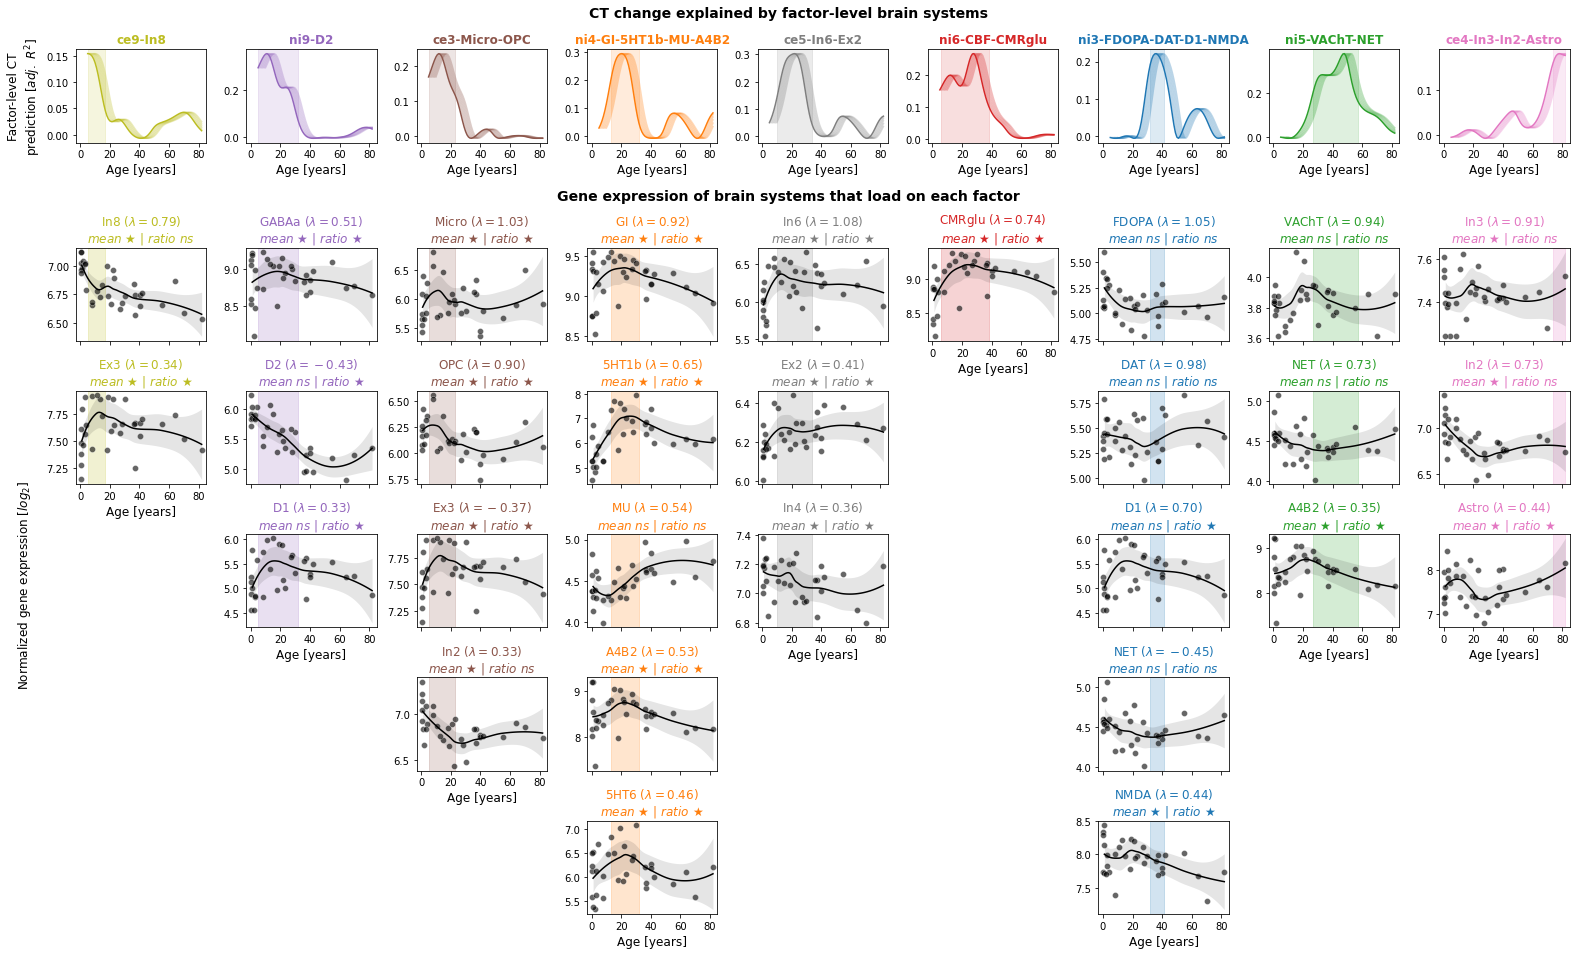

In [16]:
fig, axes = plt.subplots(7, len(predictors_sig_pm), figsize=(22,13), sharey=False, sharex=False,
                         gridspec_kw=dict(height_ratios=(1, 0.05, 1,1,1,1,1)))
colors = get_cmap("tab10")(range(len(predictors_sig)))
colors = [colors[predictors_sig.index(p)] for p in predictors_sig_pm_sorted]

for c, pred in enumerate(predictors_sig_pm_sorted):
    
    # title
    axes[0,c].set_title(pred, c=colors[c], weight="semibold", size=12)

    # Factor-level CT prediction
    pred_maxidc = plot_ct(
        ax=axes[0,c],
        pred=pred,
        color=colors[c],
        plot_sig=True
    )
    axes[0,c].set_xlabel("Age [years]", size=12)
    axes[0,c].set_xticks([0,20,40,60,80])
    axes[0,c].set_xticklabels([0,20,40,60,80])
    axes[0,c].set_xlim(-3,85)
        
    # placeholder axis
    axes[1,c].set_axis_off()
        
    # Gene expression for each gene set associated with original predictor
    # maximum 5 original predictors with absolute loadings > 0.3, sorted descending
    for r, pred_orig in enumerate(preds_orig[pred], start=2):
        
        # significance (mean)
        if res_expression_test.loc[(pred, pred_orig), "q_mean_expr"] < 0.05: s_mean = "★"
        elif res_expression_test.loc[(pred, pred_orig), "p_mean_expr"] < 0.05: s_mean = "☆"
        else: s_mean = "ns"
        
        # significance (ratio)
        if res_expression_test.loc[(pred, pred_orig), "q_mean_expr_ratio"] < 0.05: s_ratio = "★"
        elif res_expression_test.loc[(pred, pred_orig), "p_mean_expr_ratio"] < 0.05: s_ratio = "☆"
        else: s_ratio = "ns"
        
        # original predictor gene expression
        axes[r,c].set_title(
            f"{pred_orig} $(\lambda = {loadings.loc[pred_orig, pred]:.02f})$\n"
            f"$mean\ {s_mean}\ |\ ratio\ {s_ratio}$",
            c=colors[c], 
            size=12
        )
        
        plot_expr(
            ax=axes[r, c],
            pred=pred_orig,
            plot_sig=True, 
            pred_sig=pred, 
            color_sig=colors[c]
        )  
        axes[r,c].set_xlabel("")
        axes[r,c].set_xticks([0,20,40,60,80])
        axes[r,c].set_xticklabels([])
        axes[r,c].set_xlim(-3,85)
        
    axes[r,c].set_xlabel("Age [years]", size=12)
    axes[r,c].set_xticklabels([0,20,40,60,80])
    [axes[r,c].set_axis_off() for r in range(r+1,7)]
    
    
# labels
for s, y in zip(
    ["CT change explained by factor-level brain systems",
     "Gene expression of brain systems that load on each factor"], 
    [1.01, 0.815]
):
    fig.text(
        s=s,
        x=0.5,
        y=y,
        ha="center",
        va="center",
        size=14,
        c="k",
        weight="semibold",
        transform=fig.transFigure
    )

axes[0,0].set_ylabel("Factor-level CT\nprediction $[adj.\ R^2]$", size=12)
fig.text(
    s="Normalized gene expression $[log_2]$",
    rotation=90,
    x=0.018,
    y=0.4,
    ha="center",
    va="center",
    size=12,
    c="k",
    transform=fig.transFigure
)

# finalize and save
fig.tight_layout()
fig.savefig(join(plot_dir, "expression_trajectories.pdf"), bbox_inches="tight")

### Plot stat results

ce9-In8
In8
Ex3
ni9-D2
GABAa
D2
D1
ce3-Micro-OPC
Micro
OPC
Ex3
In2
ni4-GI-5HT1b-MU-A4B2
GI
5HT1b
MU
A4B2
5HT6
ce5-In6-Ex2
In6
Ex2
In4
ni6-CBF-CMRglu
CMRglu
ni3-FDOPA-DAT-D1-NMDA
FDOPA
DAT
D1
NET
NMDA
ni5-VAChT-NET
VAChT
NET
A4B2
ce4-In3-In2-Astro
In3
In2
Astro


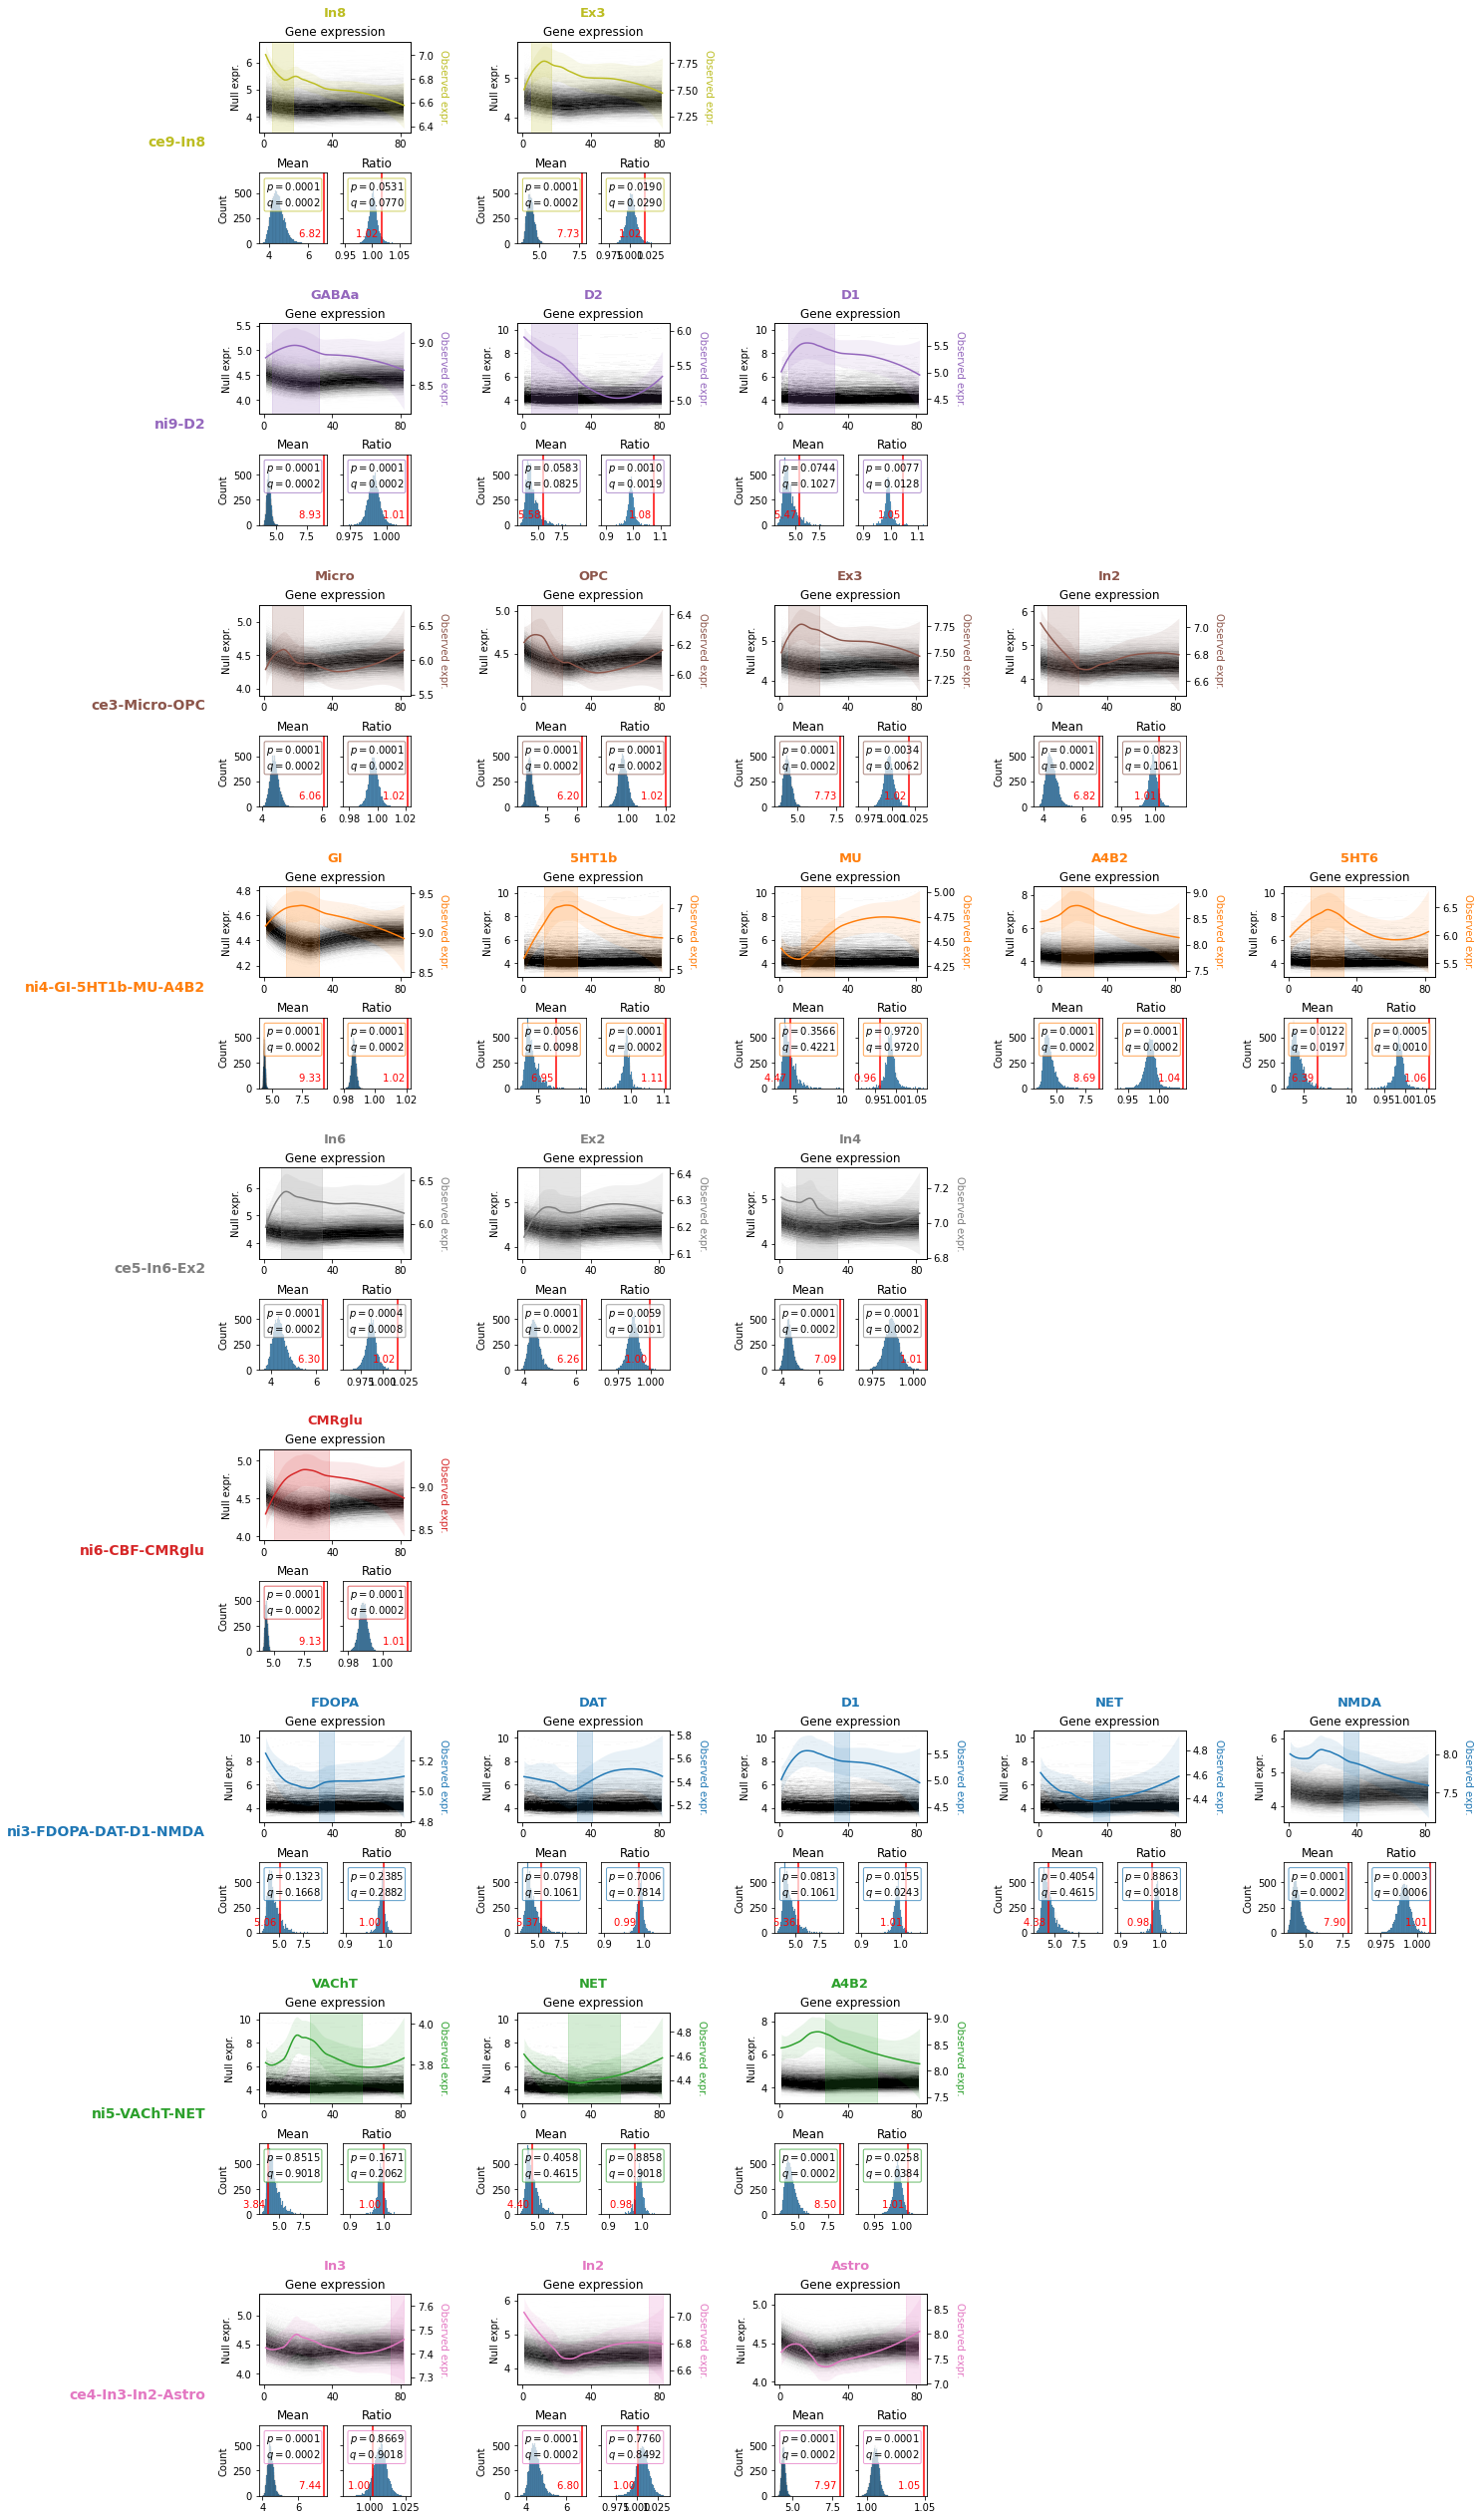

In [133]:
fig, axes = plt.subplots(len(predictors_sig_pm), 5, figsize=(20,35), constrained_layout=True,
                         gridspec_kw=dict(wspace=0.2, hspace=0.1))
colors = get_cmap("tab10")(range(len(predictors_sig)))
colors = [colors[predictors_sig.index(p)] for p in predictors_sig_pm_sorted]

for r, pred in enumerate(predictors_sig_pm_sorted):
    print(pred)
    
    # predictor name
    axes[r,0].annotate(
        pred,
        c=colors[r],
        size=14,
        weight="semibold",
        xy=(-0.35,0.5),
        xycoords="axes fraction",
        ha="right",
        va="center"
    )
    
    # iterate associated original predictors
    for c, pred_orig in enumerate(preds_orig[pred]):
        print(pred_orig)
        
        # title
        axes[r,c].set_title(pred_orig, c=colors[r], weight="semibold", size=13, pad=25)

        # sub axes
        ax_expr = axes[r,c].inset_axes((0, 0.55, 1, 0.45))
        ax_expr_right = ax_expr.twinx()
        ax_mean = axes[r,c].inset_axes((0, 0, 0.45, 0.35))
        ax_ratio = axes[r,c].inset_axes((0.45 + 0.1, 0, 0.45, 0.35))
        
        
        # plot expression data
        ax_expr.set_title("Gene expression", size=12)
        # null data
        plot_expr(
            ax=ax_expr,
            pred=pred_orig,
            plot_scatter=False,
            plot_loess=False,
            plot_sig=False, 
            plot_null=True,
            n_null=10000,
            alpha_null=0.005
        )  
        # true data
        plot_expr(
            ax=ax_expr_right,
            pred=pred_orig,
            plot_scatter=False,
            plot_loess=True,
            plot_sig=True, 
            plot_null=False,
            bl_shift=4,
            color=colors[r],
            pred_sig=pred,
            color_sig=colors[r]
        )  
        ax_expr.set_xticks([0,40,80])
        ax_expr.set_ylabel("Null expr.") 
        ax_expr_right.set_ylabel("Observed expr.", color=colors[r], rotation=-90, labelpad=15) 
        
        
        # plot histograms
        for m, var, ax in zip(
            ["mean", "ratio"],
            ["mean_expr", "mean_expr_ratio"],
            [ax_mean, ax_ratio],
        ):
            
            # title
            ax.set_title(m.capitalize(), size=12)
            
            # histo
            sns.histplot(
                null_expression_test[(pred, pred_orig)][m],
                ax=ax
            )
            ax.set_ylim(0,700)
            
            # line
            ax.axvline(res_expression_test.loc[(pred, pred_orig), var], c="r")
            
            # stat
            ax.text(
                s=f"{res_expression_test.loc[(pred, pred_orig), var]:.02f} ",
                x=res_expression_test.loc[(pred, pred_orig), var],
                y=100,
                ha="right",
                va="center",
                c="r",
                size=10
            )
            
            # p
            ax.annotate(
                f"$p = {res_expression_test.loc[(pred, pred_orig), 'p_' + var]:.04f}$\n"
                f"$q = {res_expression_test.loc[(pred, pred_orig), 'q_' + var]:.04f}$",
                xy=(0.5,0.9),
                xycoords="axes fraction",
                ha="center",
                va="top",
                size=10,
                bbox=dict(boxstyle="round,pad=0.15", fc="w", ec=colors[r], alpha=0.7)
            )
            
            # labels
            if m=="mean":
                ax.set_ylabel("Count")
            else:
                ax.set_yticklabels([])
                ax.set_ylabel("")
            
    [ax.set_axis_off() for ax in axes.ravel()]

# save
fig.savefig(join(plot_dir, "expression_trajectories_nulls.png"), bbox_inches="tight", dpi=300)